## Notebook to design PLPs for ISS 


### Requirements to run the script

This script aims to be used as an example of how to design ISS probes to target different genes. The requirements to use this scripts to design PLP are:

(1) A list of Genes to design a padlock probe (PLP) agains it

(2) The reference transcriptome of the species you are targeting in fasta format (.fasta/.fa/.fna) downloaded locally.

(3) ClustalW2 downloaded on your computer

(4) Cutadapt downloaded on your computer 


# Import packages

The first step in this script is to load the packages that the script will need. If anything fails in this step, it means most likely that you haven't installed the package yet. You can install packages with "pip install < whatever >" on the command line

In [106]:
import pandas as pd 
import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalwCommandline
import collections
from Bio import AlignIO
import random
import numpy as np
import sys
sys.path += [r"C:\Users\sergio.salas\Documents\PhD\projects\gene_design\PLP_design_package\bin"]
#print (sys.path)
import PLP_design as plp

##  Reference parameters

Please specify in the following lines where your input csv, output path and accompaning software is located in your computer

`Path`: Where do you want your output to be stored in.
`Genes`: csv containing the list of genes you want to design PLPs against
`Pathclustal`: path where the program ClustalW2 is installed. Find it by searching ClustalW2 on your folder menu, opening the location of it and copying the path here
`ref`: reference transcriptome of the species you are interested on
 `L_probe_library`:this is used to link your good target sequences/genes to L-IDs that will be used later for decoding)
`LbarID` is,from the reference PLP list,  where do you want to start from

In [107]:
path='C:/Users/sergio.salas/Documents/PhD/projects/gene_design/hower_example_6'
genes1=pd.read_csv(r"C:\Users\sergio.salas\Documents\PhD\projects\gene_design\genelist2.csv",sep=',')
genes2=pd.read_csv(r"C:\Users\sergio.salas\Documents\PhD\projects\gene_design\genelist2mouse.csv",sep=',')
pathclustal=r"C:/ProgramData/Microsoft/Windows/Start Menu/Programs/ClustalW2/ClustalW2.lnk"
ref1=r'C:/Users/sergio.salas/Documents/PhD/projects/gene_design/example/GRCh38_latest_rna.fna'
ref2=r"C:\Users\sergio.salas\Documents\PhD\projects\gene_design\Mus_musculus.GRCm39.cdna.all.fa"
L_probe_library="C:/Users/sergio.salas/Documents/PhD/projects/gene_design/example/Lprobe_Ver2.csv"
LbarID=201 # 

In [108]:
ref_list=[ref1,ref2]
genes_list=[genes1,genes2]

https://www.ensembl.org/info/data/ftp/index.html

# PARAMETERS RELATED WITH PLP DESIGN ITSELF

`selgenes`: number of sequences (out of the ones fitting your parameters), that you want to map against the transcriptome.
The more you map, the slower it will be, but the higher chance you'll have to get specific sequences.
We recommend `number_of_seqs`=7-8, for a standard ISS experiment where you want 4-5 final PLPs

`final_designed`: maximum number of PLPs that you want to design out of the number included as selgenes
`plp_length`: length of the part of the PLP hybridizing the RNA molecules
`mismatches`: is the maximum allowed mismatches between the probe and the target sequence. Anything below or equal to `mismatches` will produce a positive hit. OPTIONAL: include gc_max, gc_min, set to 50 and 65 in the default script if you want to change it 

In [109]:
number_of_seqs= 2 # number of sequences mapped/PLP
final_designed=2 # number of PLPs designed at the end/gene
plp_length=30
mismatches = 5

# Extract and align sequences

The first step in the PLP design is to extract the sequnces for the designed genes from the reference transcriptome. Since many of the genes present more than one variant, the default script for PLP design will use only the common sequences

In [110]:
#def extract_and_align(genes,ref,path,pathclustal):
import pandas as pd 
import os
from pandas import DataFrame
import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalwCommandline
import collections
from Bio import AlignIO
import random
import numpy as np
import matplotlib.pyplot as plt
isExist = os.path.exists(path+'/gene_info')
if not isExist:
    os.makedirs(path+'/gene_info') 
outfiles=[]

In [111]:
def extract_seqs(genes,ref,pre,post,column='Gene'):
    import pandas as pd 
    from pandas import DataFrame
    import Bio
    from Bio import SeqIO
    from Bio.SeqUtils import GC
    from Bio.Seq import Seq
    from Bio.SeqRecord import SeqRecord
    from Bio.Align import MultipleSeqAlignment
    from Bio.Align.Applications import ClustalwCommandline
    import collections
    from Bio import AlignIO
    import random
    import numpy as np
    in_f =open (ref, 'r+')
    headers=list()
    for line in in_f:
    #    print(line)
        if line[0] == '>':
            headers.append(line)
    #        print(line)
    dictionary=dict()
    header=[]
    seq=[]
    genesexp=genes[column].unique()
    listo=[]
    lista=[]
    for ici in genesexp:
        icis=pre+ici+post
       # icis=ici
        matching = [s for s in headers if icis in s]
        lista.append(len(matching))
        listo.append(matching)
    
    return(genesexp,listo,lista)

In [148]:
def extract_and_align_multispecies(genes_list,ref_list,path,pathclustal):
    import pandas as pd 
    import os
    from pandas import DataFrame
    import Bio
    from Bio import SeqIO
    from Bio.SeqUtils import GC
    from Bio.Seq import Seq
    from Bio.SeqRecord import SeqRecord
    from Bio.Align import MultipleSeqAlignment
    from Bio.Align.Applications import ClustalwCommandline
    import collections
    from Bio import AlignIO
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    isExist = os.path.exists(path+'/gene_info')
    if not isExist:
        os.makedirs(path+'/gene_info') 
    outfiles=[]
    genesexp=list()
    listoref=list()
    lista=list()
    pre=['(','gene_symbol:']
    post=[')',' description']
    for i in range(0,len(genes_list)):
        ge,lor,la=extract_seqs(genes_list[i],ref_list[i],pre[i],post[i])
        genesexp.append(ge)
        listoref.append(lor)
        lista.append(la)
    notfound=[]
    for holi in range(0,len(genesexp[0])):
        ie=0
        tot=0
        for s in range(0,len(lista)):
            tot=tot+(lista[s][holi]>0)*1
        if tot<len(lista):  
            print("Gene "+genesexp[holi] +" was not found")
            notfound.append(genesexp[holi]) 
        else: 
            seqs=[]
            for species in range(0,len(genesexp)):
                print(species)
                refpath=path+"/gene_info/"+genesexp[species][holi]
                ge=genesexp[species]
                lo=listoref[species]
                la=lista[species]
                gen=ge[holi]
                goi=lo[holi]
                print('Starting '+gen)
                print()
    #            refpath=path+'/gene_info'+'/'+gen
                import os
                if not os.path.exists(refpath):
                    os.makedirs(refpath)
                sq=plp.extractseq(goi,ref_list[species])
                seqs=seqs+sq
            refpath=path+"/gene_info/"+genesexp[0][holi]
            with open(refpath+'/seqs.fasta', 'w') as f:
                for item in seqs:
                    f.write("%s\n" % item)
            clustalw_exe = pathclustal
            cmd = ClustalwCommandline(clustalw_exe,
            infile=refpath+'/seqs.fasta')
            stdout, stderr = cmd()
            alignment = AlignIO.read(refpath+'/seqs.aln', "clustal")
            st=''
            cseqs=[]
            common=[]
            for esa in range(0,alignment.get_alignment_length()):
                un=alignment[:,esa]
                col=collections.Counter(un).most_common(1)[0]
                common.append(col[1])
                if col[1]==len(alignment):
                    st=st+str(col[0])
                else:
                    if len(st)>35:
                        cseqs.append(st)
            #            cseqs=[]
                        st=''
            if len(st)>35:
                        cseqs.append(st)
                        st=''
            freqseq=np.zeros([len(alignment[:,1]),int(alignment.get_alignment_length())])
            for es2 in range(0,alignment.get_alignment_length()):
                        un=alignment[:,es2]
                        for pos2 in range(0,len(un)):
                            if un[pos2]=='-':
                                freqseq[pos2,es2]==0
                            else:
                                cnt=0
                                for el in un:
                                    cnt=cnt+(un[pos2]==el)*1
                                freqseq[pos2,es2]=cnt 
            plp.plot_alignment(refpath,alignment,common)
            plp.plot_alignment_of_variants(refpath,freqseq,alignment)
            with open(refpath+'/aligned_seqs.fasta', 'w') as f:
                comseq=1
                for item in cseqs:
                    f.write(">"+ gen+ " Seq"+str(comseq)+ "\n" )
                    f.write("%s\n" % item)
                    comseq=comseq+1
            records=[]
            for ia in range(0,len(goi)-1):
                records.append(SeqRecord(Seq(seqs[ia]),id=goi[ia]))       
            # Loads fasta
            ie=0
            for seq_record in SeqIO.parse(refpath+"/aligned_seqs.fasta", "fasta"):
                seq_record = seq_record.upper()
                #print (seq_record)
                ie=ie+1
                targetsall,outfiles = plp.findtargets(seq_record,refpath,ie,outfiles)
    #           print(targetsall)
        of=pd.DataFrame(outfiles)
        of.to_csv(path+'/outfiles.csv')
        selected,unigene=plp.retrieve_targets(outfiles,path)
        for ela in range(0,len(lista)):
            hits=dict(zip(genesexp[-1],lista[ela]))
            selected['exp_hits_'+str(ela)]=selected['Gene'].map(hits)
        return selected,unigene,notfound   

0
Starting SOX1

1
Starting Sox1

Extracting all possible targets for all genes


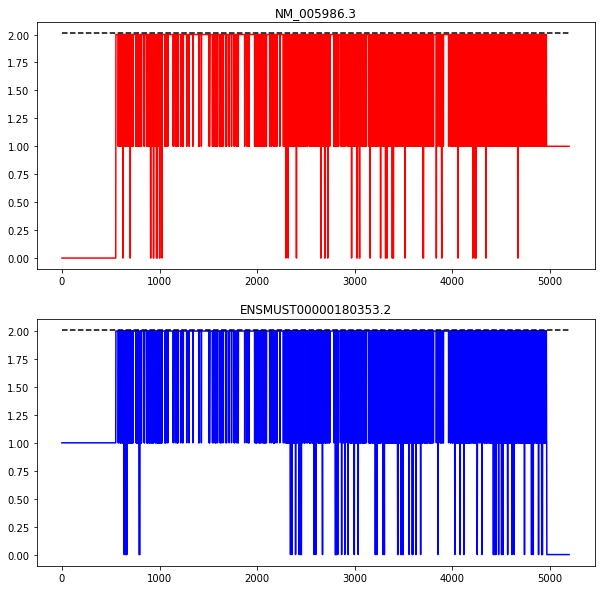

In [151]:
sequences,found_genes,notfound_genes=extract_and_align_multispecies(genes_list,ref_list,path,pathclustal)

From the previous script, we return `sequences`, which include all the potential sequences (not mapped yet) for all genes targeted. `found_genes` include the list of genes that we have been able to find k-mers fullfiling the PLP requirements. `not_found_genes` include the list of genes that we haven't been able to find/ we haven't been able to find any k-mer that fullfils the requirements. Those can be (1) too short genes or (2) genes with too many variants and no comon sequence among them

# Select a subsample of potential targets

We subsample the long list of potential targets/sequences to check for specificity. The returned object `selected_sequences` has the same format as sequences, but has only the amount of targets/gene specified in `number_of_seqs`

In [154]:
sequences

,Unnamed: 0,Gene,Position,Sequence,exp_hits_0,exp_hits_1
0,0,Sox1,27,CCAAGATGCACAACTCGGAGATCAGCAAGC,1,1
1,1,Sox1,28,CAAGATGCACAACTCGGAGATCAGCAAGCG,1,1
2,2,Sox1,29,AAGATGCACAACTCGGAGATCAGCAAGCGC,1,1
3,3,Sox1,31,GATGCACAACTCGGAGATCAGCAAGCGCCT,1,1
0,0,Sox1,27,CCAAGATGCACAACTCGGAGATCAGCAAGC,1,1
1,1,Sox1,28,CAAGATGCACAACTCGGAGATCAGCAAGCG,1,1
2,2,Sox1,29,AAGATGCACAACTCGGAGATCAGCAAGCGC,1,1
3,3,Sox1,31,GATGCACAACTCGGAGATCAGCAAGCGCCT,1,1
0,0,Sox1,5,CGAGTGGAAGGTCATGTCCGAGGCCGAGAA,1,1
1,1,Sox1,7,AGTGGAAGGTCATGTCCGAGGCCGAGAAGC,1,1


In [152]:
selected_sequences=plp.select_sequences(path,sequences,found_genes,number_of_seqs,subgroup=1)

In [162]:
def map_sequences_specific_transcriptome(selected,ref,subgroup=1):
    for spe in range(0,len(ref)):
        kmers =list(selected['Sequence'])
        transcriptome = (ref[spe])
        seqlist = []
        hitlist = []
        lenlist = []
        s=0
        for sequence in kmers:
            s=s+1
            print ('Looking for sequence ('+str(s)+'/'+str(len(kmers))+'): '+sequence + ' allowing ' + str(mismatches) + ' mismatches')
            output= !C:/Users/sergio.salas/Downloads/cutadapt-3.4.exe -a $sequence --overlap 30 $transcriptome --no-indels -e $mismatches --action=retain --untrimmed-output C:\Users\sergio.salas\Downloads\here  
            n=0
            c2 = [line for line in output if line[0:1] == '>']
            print ('Found '+str(len(c2))+' hits')
            seqlist.append (sequence)
            hitlist.append (c2)
            lenlist.append (len(c2))
        expoutput = pd.DataFrame(list(zip(seqlist, hitlist, lenlist)),
                       columns =['sequence_with_Ns_'+str(spe), 'hits_'+str(spe), 'number_of_hits_'+str(spe)])
        bcf_all=pd.concat([selected.reset_index(),expoutput],axis=1)
        selected=bcf_all
    bcf_all.to_csv(path+'mapped_sequences'+str(subgroup)+'.csv')
    return bcf_all

In [157]:
def map_sequences_specific_transcriptome(selected,ref,subgroup=1):
    kmers =list(selected['Sequence'])
    transcriptome = (ref)
    seqlist = []
    hitlist = []
    lenlist = []
    s=0
    for sequence in kmers:
        s=s+1
        print ('Looking for sequence ('+str(s)+'/'+str(len(kmers))+'): '+sequence + ' allowing ' + str(mismatches) + ' mismatches')
        output= !C:/Users/sergio.salas/Downloads/cutadapt-3.4.exe -a $sequence --overlap 30 $transcriptome --no-indels -e $mismatches --action=retain --untrimmed-output C:\Users\sergio.salas\Downloads\here  
        n=0
        c2 = [line for line in output if line[0:1] == '>']
        print ('Found '+str(len(c2))+' hits')
        seqlist.append (sequence)
        hitlist.append (c2)
        lenlist.append (len(c2))
    expoutput = pd.DataFrame(list(zip(seqlist, hitlist, lenlist)),
                   columns =['sequence_with_Ns', 'hits', 'number_of_hits'])
    bcf_all=pd.concat([selected.reset_index(),expoutput],axis=1)
    bcf_all.to_csv(path+'mapped_sequences'+str(subgroup)+'.csv')
    return bcf_all

In [163]:
sel_mapped_seqs=map_sequences_specific_transcriptome(selected_sequences,ref_list,subgroup=1)

Looking for sequence (1/2): GCATGATGATGGAGACCGACCTGCACTCGC allowing 5 mismatches
Found 1 hits
Looking for sequence (2/2): CGCAAGACCAAGACGCTGCTCAAGAAGGAC allowing 5 mismatches
Found 4 hits
Looking for sequence (1/2): GCATGATGATGGAGACCGACCTGCACTCGC allowing 5 mismatches
Found 1 hits
Looking for sequence (2/2): CGCAAGACCAAGACGCTGCTCAAGAAGGAC allowing 5 mismatches
Found 5 hits


In [164]:
sel_mapped_seqs

,level_0,index,Unnamed: 0,Gene,Position,Sequence,exp_hits_0,exp_hits_1,sequence_with_Ns_0,hits_0,number_of_hits_0,sequence_with_Ns_1,hits_1,number_of_hits_1
0,0,3,3,Sox1,35,GCATGATGATGGAGACCGACCTGCACTCGC,1,1,GCATGATGATGGAGACCGACCTGCACTCGC,[>NM_005986.3 Homo sapiens SRY-box transcripti...,1,GCATGATGATGGAGACCGACCTGCACTCGC,[>ENSMUST00000180353.2 cdna chromosome:GRCm39:...,1
1,1,10,10,Sox1,51,CGCAAGACCAAGACGCTGCTCAAGAAGGAC,1,1,CGCAAGACCAAGACGCTGCTCAAGAAGGAC,[>NM_004189.4 Homo sapiens SRY-box transcripti...,4,CGCAAGACCAAGACGCTGCTCAAGAAGGAC,[>ENSMUST00000180353.2 cdna chromosome:GRCm39:...,5
